<a href="https://www.kaggle.com/code/ayodejiibrahimlateef/trade-deficits-tariff-impacts-gb-approach?scriptVersionId=246975046" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Import Libraries & Data

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import joblib


# Load Dataset
df = pd.read_csv('/kaggle/input/us-tariffs-2025/Tariff Calculations plus Population.csv', delimiter=';', thousands=',')
df.head()

,Country,US 2024 Deficit,US 2024 Exports,US 2024 Imports (Customs Basis),Trump Tariffs Alleged,Trump Response,Population
0,Afghanistan,-11.1,11.4,22.6,49%,25%,41454761.0
1,Albania,13.4,141.7,128.3,10%,10%,2745972.0
2,Algeria,-1447.1,1014.5,2461.6,59%,29%,46164219.0
3,Andorra,1.5,4.9,3.4,10%,10%,80856.0
4,Angola,-1186.9,682.4,1869.2,63%,32%,36749906.0


# Check Data Types and Column Names

In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 204 entries, 0 to 203
Data columns (total 7 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Country                          204 non-null    object 
 1   US 2024 Deficit                  204 non-null    float64
 2   US 2024 Exports                  204 non-null    float64
 3   US 2024 Imports (Customs Basis)  204 non-null    float64
 4   Trump Tariffs Alleged            204 non-null    object 
 5   Trump Response                   204 non-null    object 
 6   Population                       172 non-null    float64
dtypes: float64(4), object(3)
memory usage: 11.3+ KB


# Check for Missing Values

In [3]:
# Check for missing values in each column
missing_values = df.isnull().sum()
print("Missing values per column:\n", missing_values)


Missing values per column:
 Country                             0
US 2024 Deficit                     0
US 2024 Exports                     0
US 2024 Imports (Customs Basis)     0
Trump Tariffs Alleged               0
Trump Response                      0
Population                         32
dtype: int64


# Check for Numeric Format Issues

In [4]:
# Inspect columns to ensure numeric columns have no formatting issues (like commas, percentages)
for col in ['US 2024 Deficit', 'US 2024 Exports', 'US 2024 Imports (Customs Basis)', 'Trump Tariffs Alleged', 'Trump Response', 'Population']:
    print(f"\nColumn '{col}' unique values:\n", df[col].unique()[:10])  # shows first 10 unique values



Column 'US 2024 Deficit' unique values:
 [-1.1100e+01  1.3400e+01 -1.4471e+03  1.5000e+00 -1.1869e+03  7.1300e+01
  5.5000e+02  2.0788e+03  3.9200e+01  7.1480e+02]

Column 'US 2024 Exports' unique values:
 [1.1400e+01 1.4170e+02 1.0145e+03 4.9000e+00 6.8240e+02 7.2500e+01
 5.7380e+02 9.1710e+03 1.6080e+02 7.2550e+02]

Column 'US 2024 Imports (Customs Basis)' unique values:
 [2.2600e+01 1.2830e+02 2.4616e+03 3.4000e+00 1.8692e+03 1.2000e+00
 2.3800e+01 7.0922e+03 1.2160e+02 1.0700e+01]

Column 'Trump Tariffs Alleged' unique values:
 ['49%' '10%' '59%' '63%' '74%' '47%' '20%' '70%' '88%' '97%']

Column 'Trump Response' unique values:
 ['25%' '10%' '29%' '32%' '37%' '24%' '35%' '23%' '44%' '49%']

Column 'Population' unique values:
 [41454761.  2745972. 46164219.    80856. 36749906.       nan    93316.
 45538401.  2990900.   107359.]


# Check for duplicate rows

In [5]:
# Check for duplicate rows
duplicates = df.duplicated().sum()
print("Number of duplicate rows:", duplicates)


Number of duplicate rows: 0


# Quick descriptive statistics to spot unusual values

In [6]:
# Quick descriptive statistics to spot unusual values
df.describe(include='all')


,Country,US 2024 Deficit,US 2024 Exports,US 2024 Imports (Customs Basis),Trump Tariffs Alleged,Trump Response,Population
count,204,204.000000,204.000000,204.000000,204,204,1.720000e+02
unique,204,NaN,NaN,NaN,52,37,NaN
top,Afghanistan,NaN,NaN,NaN,10%,10%,NaN
freq,1,NaN,NaN,NaN,130,141,NaN
mean,NaN,-5884.929902,10139.176471,16031.058333,NaN,NaN,4.286567e+07
std,NaN,31981.610534,44538.644239,71428.718556,NaN,NaN,1.602899e+08
min,NaN,-295401.600000,0.600000,0.100000,NaN,NaN,9.816000e+03
25%,NaN,-117.550000,59.175000,15.200000,NaN,NaN,8.149932e+05
50%,NaN,30.400000,227.500000,186.550000,NaN,NaN,6.833880e+06
75%,NaN,194.300000,1973.425000,2006.475000,NaN,NaN,2.831881e+07


# Quick Visual Check for Outliers

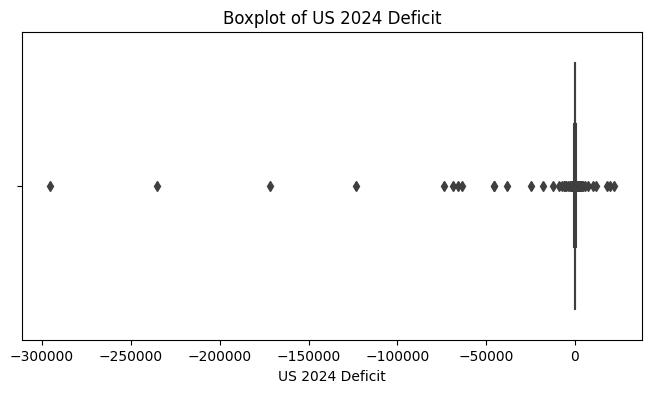

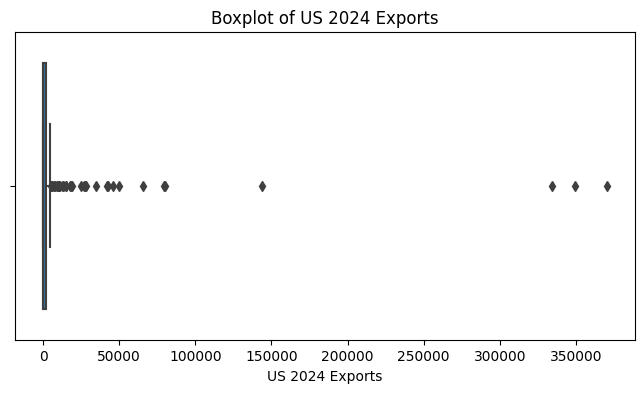

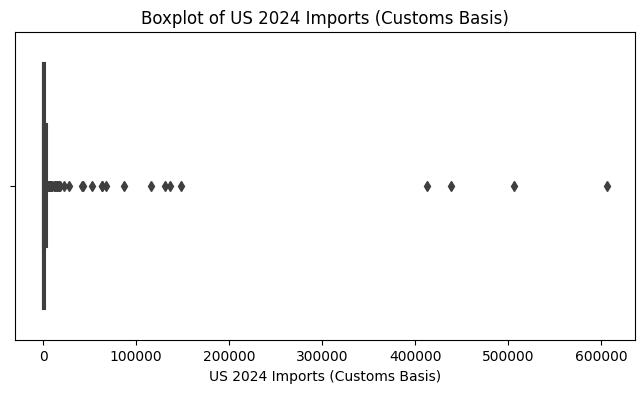

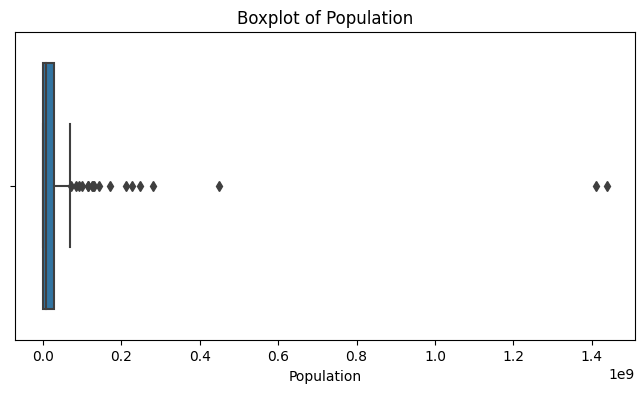

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

# Visual inspection for outliers in numeric columns
numeric_cols = ['US 2024 Deficit', 'US 2024 Exports', 'US 2024 Imports (Customs Basis)', 'Population']

for col in numeric_cols:
    plt.figure(figsize=(8,4))
    sns.boxplot(x=df[col].astype(str).str.replace(',', '').astype(float))
    plt.title(f'Boxplot of {col}')
    plt.show()


# Fix Missing Values, Numeric Formatting Issues, Outliers
# Genuine outliers such as China/India for population but i am going to use median for this project

In [8]:
# Fill missing population with median
df['Population'].fillna(df['Population'].median(), inplace=True)

# Clean percentage columns and convert to numeric
df['Trump Tariffs Alleged'] = df['Trump Tariffs Alleged'].str.rstrip('%').astype(float)
df['Trump Response'] = df['Trump Response'].str.rstrip('%').astype(float)

# Remove commas from numeric columns explicitly
cols_to_clean = ['US 2024 Deficit', 'US 2024 Exports', 'US 2024 Imports (Customs Basis)']
for col in cols_to_clean:
    df[col] = df[col].astype(str).str.replace(',', '').astype(float)

# Confirm missing values and data types fixes

In [9]:
# Check again for missing values and data types
df.info()
df.isnull().sum()

# Ensure no duplicates
assert df.duplicated().sum() == 0, "Duplicates found!"


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 204 entries, 0 to 203
Data columns (total 7 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Country                          204 non-null    object 
 1   US 2024 Deficit                  204 non-null    float64
 2   US 2024 Exports                  204 non-null    float64
 3   US 2024 Imports (Customs Basis)  204 non-null    float64
 4   Trump Tariffs Alleged            204 non-null    float64
 5   Trump Response                   204 non-null    float64
 6   Population                       204 non-null    float64
dtypes: float64(6), object(1)
memory usage: 11.3+ KB


# EDA & Visualization

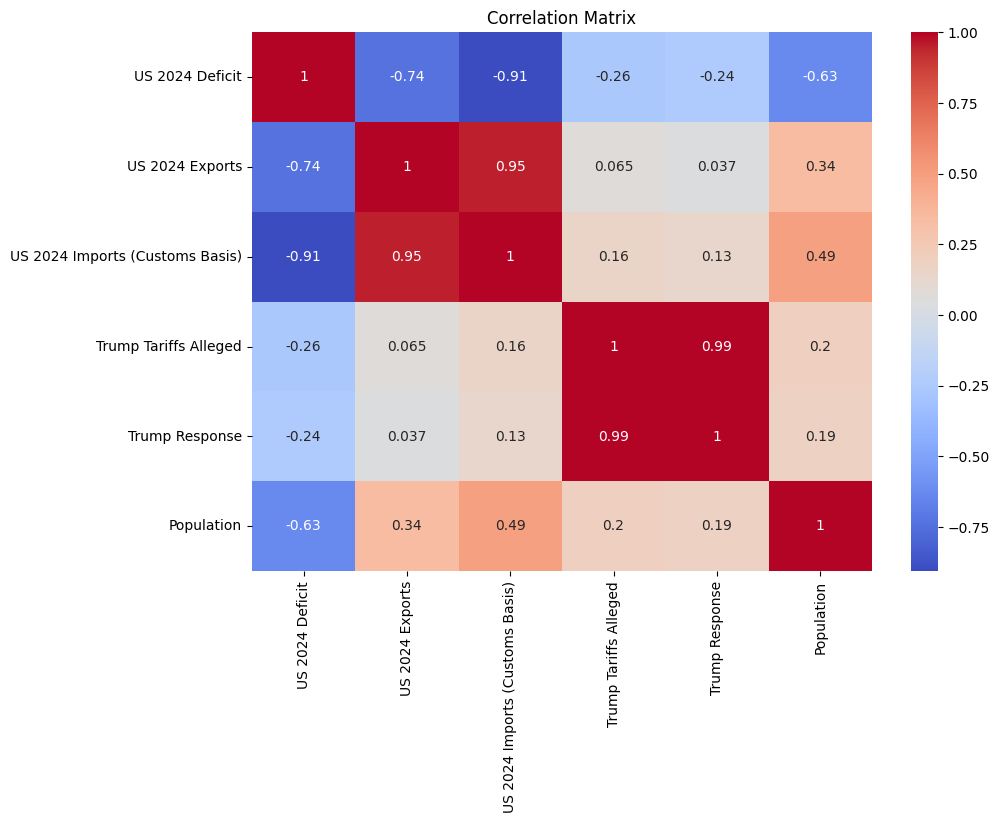

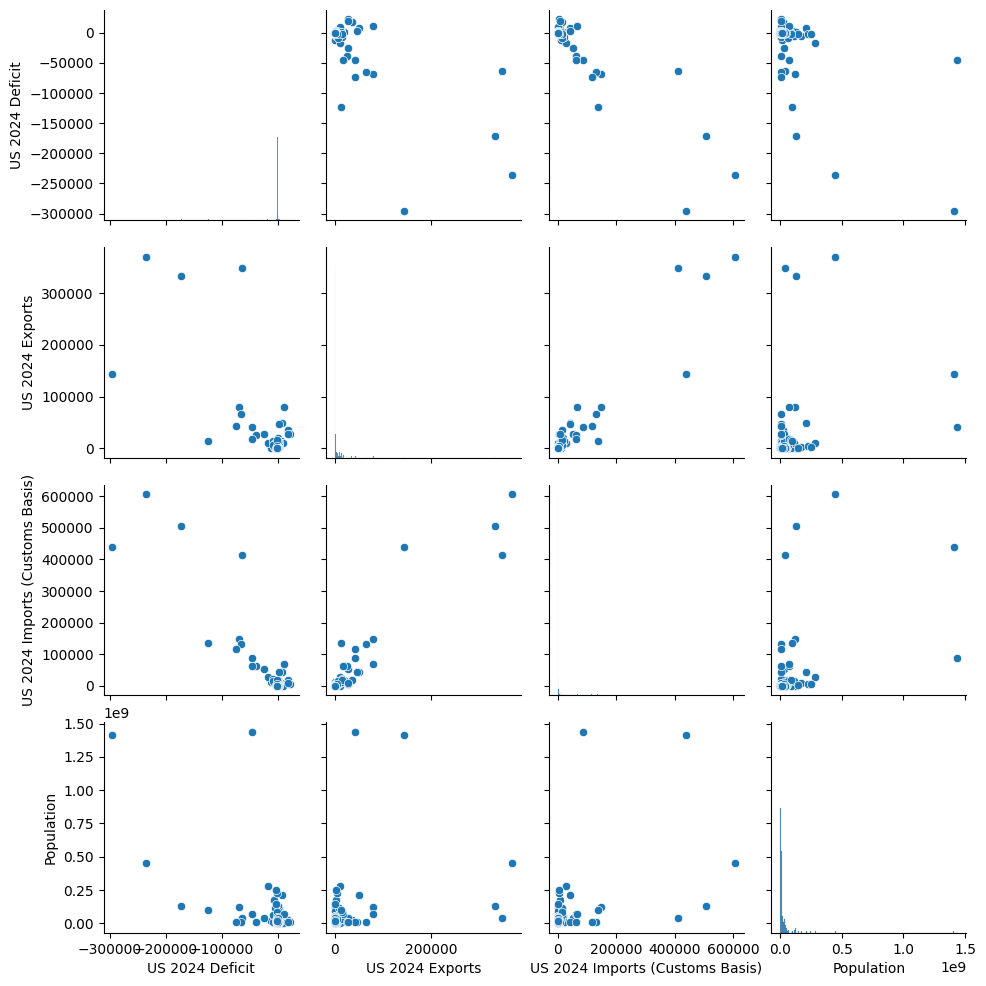

In [10]:
# Correlation heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

# Pairplots
sns.pairplot(df[['US 2024 Deficit', 'US 2024 Exports', 'US 2024 Imports (Customs Basis)', 'Population']])
plt.show()


In [11]:
import numpy as np  

df['log_exports']  = np.log1p(df['US 2024 Exports'])
df['log_imports']  = np.log1p(df['US 2024 Imports (Customs Basis)'])
df['log_pop']      = np.log1p(df['Population'])

df['tariff_diff']      = df['Trump Tariffs Alleged'] - df['Trump Response']
df['trade_balance_rt'] = df['US 2024 Exports'] / df['US 2024 Imports (Customs Basis)']

df['deficit_signedlog'] = np.sign(df['US 2024 Deficit']) * np.log1p(np.abs(df['US 2024 Deficit']))

feature_cols = [
    'US 2024 Exports', 'US 2024 Imports (Customs Basis)', 'Population',
    'log_exports', 'log_imports', 'log_pop',
    'tariff_diff', 'trade_balance_rt'
]
X = df[feature_cols]
y = df['deficit_signedlog']


# Multicollinearity:

# High correlation between Exports and Imports, and between Trump Tariffs Alleged and Trump Response can cause issues in predictive models.

# Advanced Analysis (Feature Engineering) [Refactored to handle multicollinearity]

In [12]:
# Tariff difference (highly correlated, replace original two columns)
df['Tariff Difference'] = df['Trump Tariffs Alleged'] - df['Trump Response']

# Trade Balance Ratio ( to handle multicollinearity)
df['Trade Balance Ratio'] = df['US 2024 Exports'] / df['US 2024 Imports (Customs Basis)']

# Per capita metrics
df['Imports per Capita'] = (df['US 2024 Imports (Customs Basis)'] * 1e6) / df['Population']
df['Exports per Capita'] = (df['US 2024 Exports'] * 1e6) / df['Population']

# Data Splitting & Scaling (Adjusted features)

In [13]:
feature_cols = [
    'US 2024 Exports',
    'US 2024 Imports (Customs Basis)',
    'Population',
    'log_exports',
    'log_imports',
    'log_pop',
    'tariff_diff',
    'trade_balance_rt'
]

X = df[feature_cols]
y = df['deficit_signedlog']

# 2. Repeated-KFold object  ----------------------------
from sklearn.model_selection import RepeatedKFold
rkf = RepeatedKFold(n_splits=5, n_repeats=10, random_state=42)

# 3. Model dictionary with Pipelines  ------------------
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

models = {
    'Linear': Pipeline([('scale', StandardScaler()), ('lin', LinearRegression())]),
    'Ridge':  Pipeline([('scale', StandardScaler()), ('ridge', Ridge())]),
    'Lasso':  Pipeline([('scale', StandardScaler()), ('lasso', Lasso())]),
    'RandomForest':     RandomForestRegressor(random_state=42),
    'GradientBoosting': GradientBoostingRegressor(random_state=42)
}

# 4. Cross-validation comparison  ----------------------
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, mean_absolute_error

mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)

for name, model in models.items():
    cv_mae = -cross_val_score(model, X, y, cv=rkf, scoring=mae_scorer).mean()
    cv_r2  =  cross_val_score(model, X, y, cv=rkf, scoring='r2').mean()
    print(f"{name:<15} MAE(log$): {cv_mae:.3f} | R²: {cv_r2:.3f}")


Linear          MAE(log$): 2.836 | R²: 0.504
Ridge           MAE(log$): 2.782 | R²: 0.565
Lasso           MAE(log$): 2.972 | R²: 0.612
RandomForest    MAE(log$): 0.476 | R²: 0.966
GradientBoosting MAE(log$): 0.437 | R²: 0.968


# **Quick hyper-parameter tune on Gradient Boosting**

In [14]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform

param_dist = {
    'n_estimators': randint(500, 2000),
    'learning_rate': uniform(0.01, 0.15),
    'max_depth': randint(2, 5),
    'subsample': uniform(0.6, 0.4),
    'min_samples_leaf': randint(1, 10)
}

rs = RandomizedSearchCV(
    GradientBoostingRegressor(random_state=42),
    param_distributions=param_dist,
    n_iter=80,
    cv=rkf,
    scoring='neg_mean_absolute_error',
    n_jobs=-1,
    verbose=1,
    random_state=42
)
rs.fit(X, y)

print("Best CV MAE(log$):", -rs.best_score_)
print("Best params       :", rs.best_params_)

best_gb = rs.best_estimator_

Fitting 50 folds for each of 80 candidates, totalling 4000 fits
Best CV MAE(log$): 0.39739984293583597
Best params       : {'learning_rate': 0.022127998949907288, 'max_depth': 4, 'min_samples_leaf': 1, 'n_estimators': 1266, 'subsample': 0.9212559025519583}


# **Save the trained model and feature list**

In [15]:
import joblib

joblib.dump({
    'model': best_gb,
    'feature_cols': feature_cols
}, 'trade_deficit_gradient_boosting.pkl')

['trade_deficit_gradient_boosting.pkl']

**Finalised Workflow (Quick Checklist)**

Data Preparation & Validation

Data Cleaning (missing, formats, outliers)

EDA (correlation, distributions, multicollinearity)

Feature Engineering (log, ratios, per‑capita)

Modeling (pipeline CV across 5 algorithms)

Hyper‑parameter Tuning (GBR Randomised Search)

Model Save & Documentation